In [1]:
import os 
import torch
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K

from keras.layers import Dense,Input
from keras.models import Sequential
import keras_tuner
import multiprocessing
from tqdm.auto import tqdm
import pickle
import matplotlib.pyplot as plt


from sampler_PDV_bnp import * 
from pricing_vix_neural_bnp import * 
from generate_parameters_PDV import *

Cannot import yf


In [2]:
os.getcwd()
os.chdir(r'...\neural_network')

## <font color='royalblue'>Loading the pre-trained network</font>

In [3]:
loaded_model = keras.models.load_model('model_NN_batch64-7Bayesian',compile=False)

print('ARCHITECTURE OF THE NETWORK')
print(loaded_model.summary())

for i, layer in enumerate (loaded_model.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('no activation attribute')

ARCHITECTURE OF THE NETWORK
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 448)               6720      
                                                                 
 dense_1 (Dense)             (None, 64)                28736     
                                                                 
 dense_2 (Dense)             (None, 224)               14560     
                                                                 
 dense_3 (Dense)             (None, 416)               93600     
                                                                 
 dense_4 (Dense)             (None, 128)               53376     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 197,121
Traina

In [3]:
## Load the scalings

os.chdir(r'model_NN_batch64-7Bayesian_scaling')

mean_scaling_VIX, std_scaling_VIX = np.load('mean_scaling_VIX.npy',allow_pickle=True),np.load('std_scaling_VIX.npy',allow_pickle=True)
mean_scaling_Rs, std_scaling_Rs= np.load('mean_scaling_Rs.npy',allow_pickle=True),np.load('std_scaling_Rs.npy',allow_pickle=True)
mean_scaling_parameters, std_scaling_parameters= np.load('mean_scaling_parameters.npy',allow_pickle=True),np.load('std_scaling_parameters.npy',allow_pickle=True)

In [4]:
# Values taken all from Table 3 (Guyon and Lekeufack '23)

parameters=torch.tensor([55,10,20,3,0.04,-0.13,0.65,0.0,0.25,0.5]) #realistic paths

lam10_k,lam11_k,beta1_k,beta12_k,theta1_k=parameters[0], parameters[1], parameters[5], parameters[7], parameters[8]
lam20_k,lam21_k=parameters[2], parameters[3]
beta0_k=parameters[4]
beta2_k=parameters[6]
theta2_k=parameters[-1]


R1_init_k,R2_init_k=torch.tensor([0.078,0.16]),torch.tensor([0.007,0.016])

In [5]:
N=10
timestep_per_day = 10 # number of timestep per business day (do not change)
vix_N=10000
maturity=1

torch_mc1 = TorchMonteCarloExponentialModel(lam1=torch.tensor([lam10_k,lam11_k]), lam2=torch.tensor([lam20_k,lam21_k]),
                                           betas=torch.tensor([beta0_k, beta1_k, beta2_k]), R_init1=R1_init_k,
                                           R_init2=R2_init_k,theta1=theta1_k, theta2=theta2_k, N=N, vix_N=vix_N,
                                           maturity=maturity, parabolic=beta12_k,
                                            parabolic_offset=torch.tensor(0),timestep_per_day=timestep_per_day,
                                            device=device) 
torch_mc1.simulate(save_R=True)
list_of_mat_idxs_vix=torch.arange(0,maturity*252* timestep_per_day)

In [ ]:
# Neural VIX
vixy=neural_vix(loaded_model,parameters,torch_mc1,mean_scaling_VIX,std_scaling_VIX,
                    mean_scaling_parameters,std_scaling_parameters,mean_scaling_Rs,
                    std_scaling_Rs,list_of_mat_idxs_vix,N,[k for k in list_of_mat_idxs_vix],device)

In [9]:
# This chunk computes the VIX with NESTED MC: it is very slow, but it is the benchmark for the goodness of fit of the neural VIX
vix_nested=torch.stack([torch_mc1.compute_vix_path(k,n_batch=200) for k in tqdm(range(N))])

  0%|          | 0/10 [00:00<?, ?it/s]

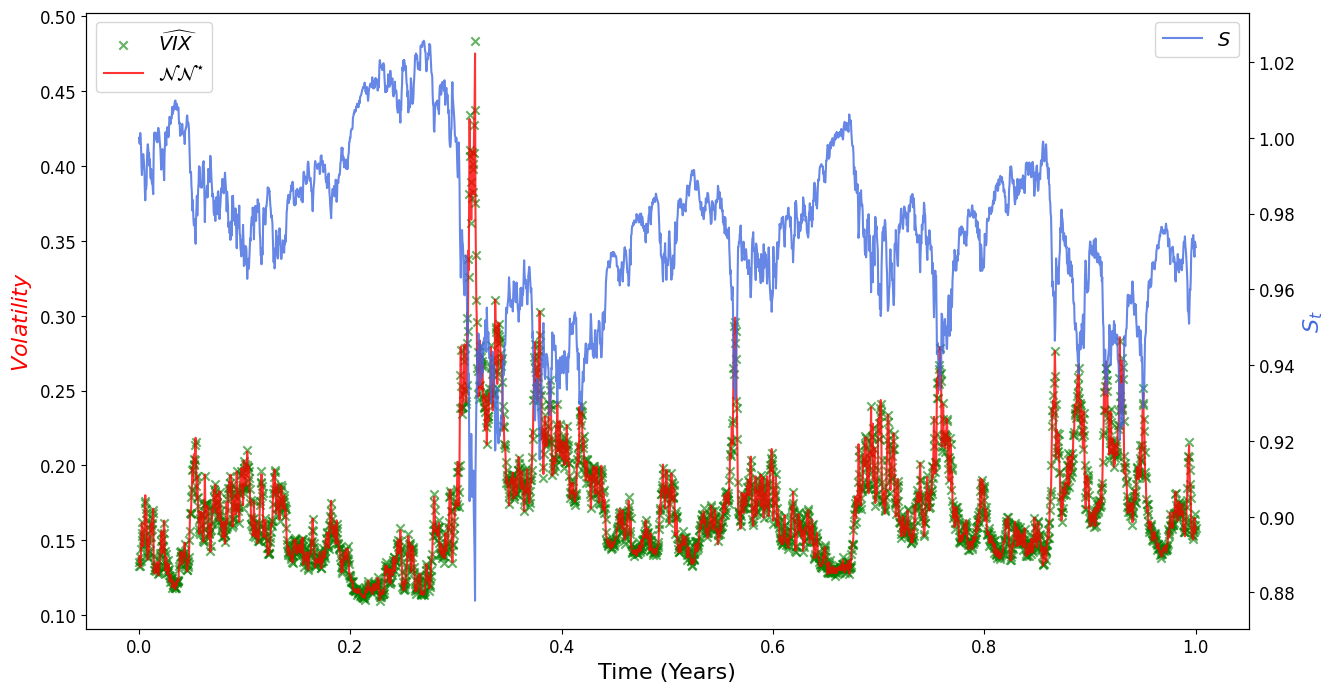

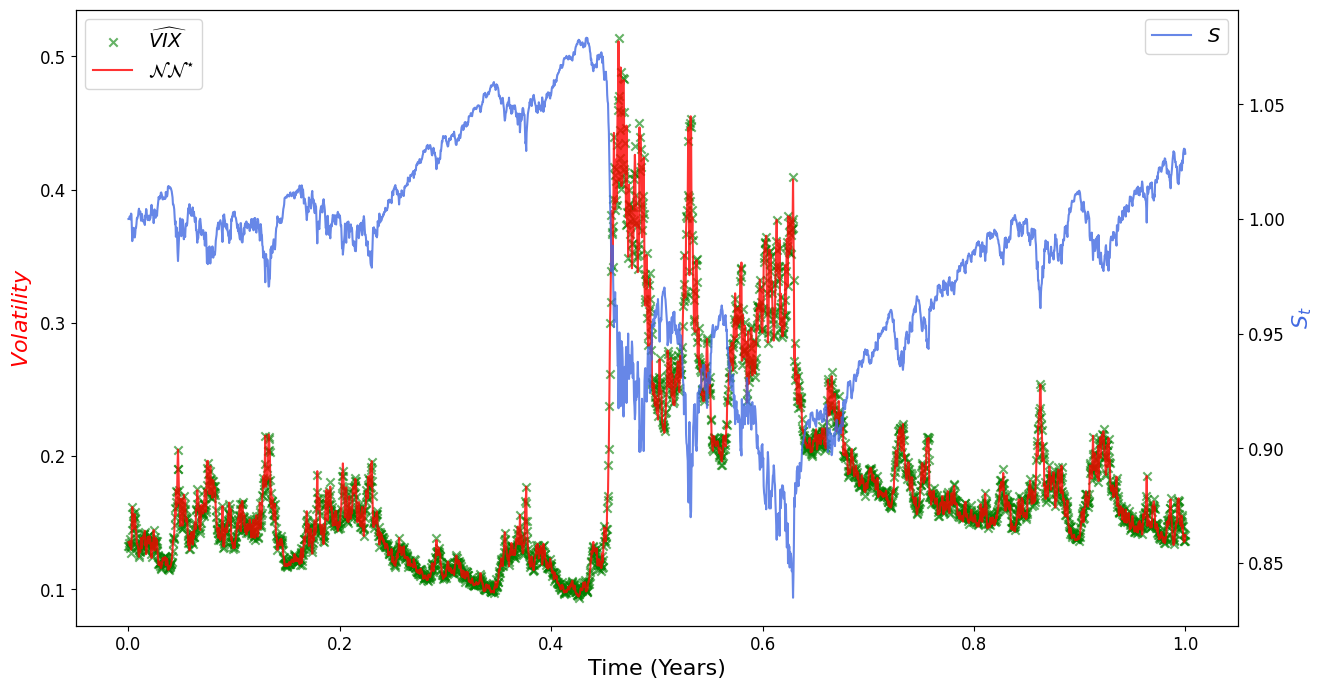

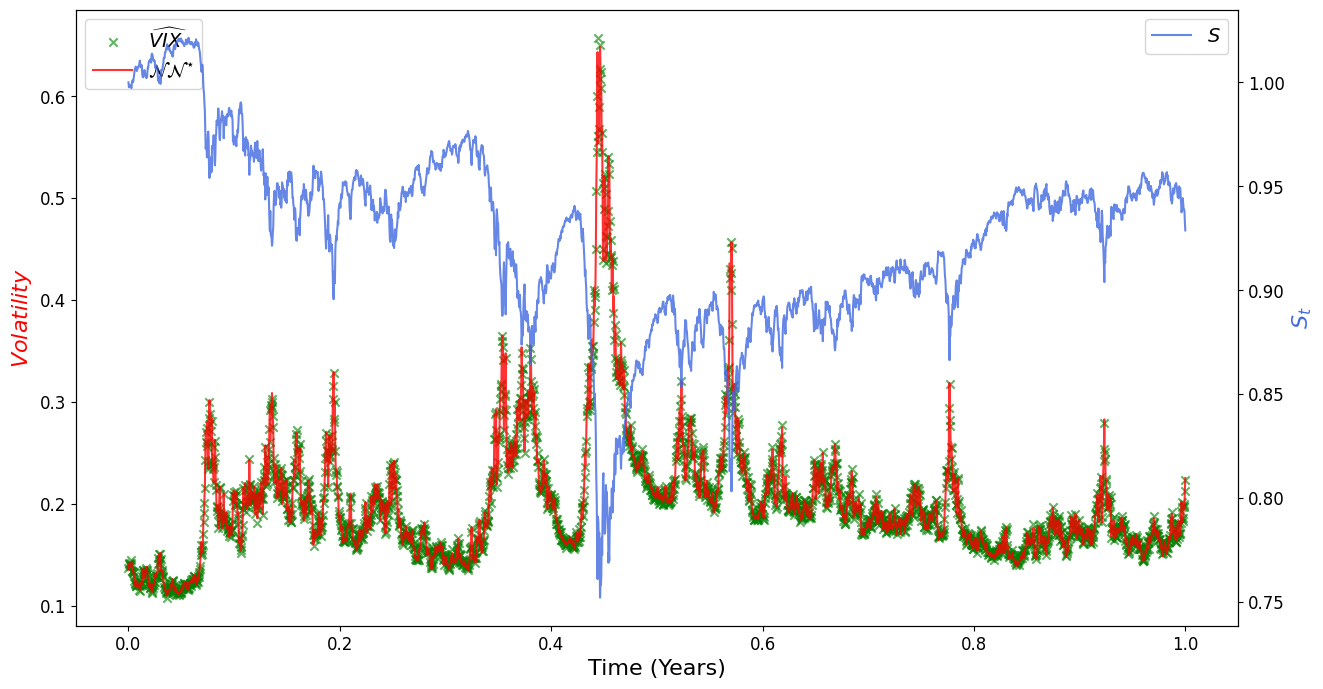

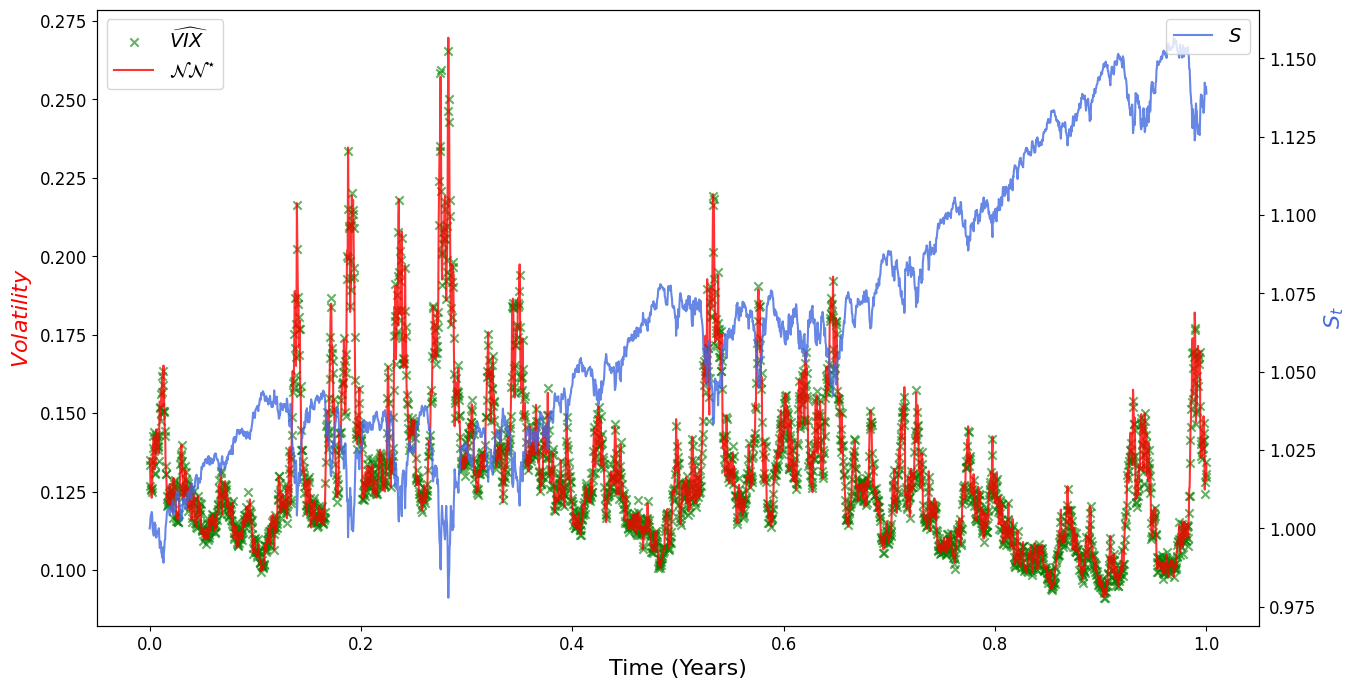

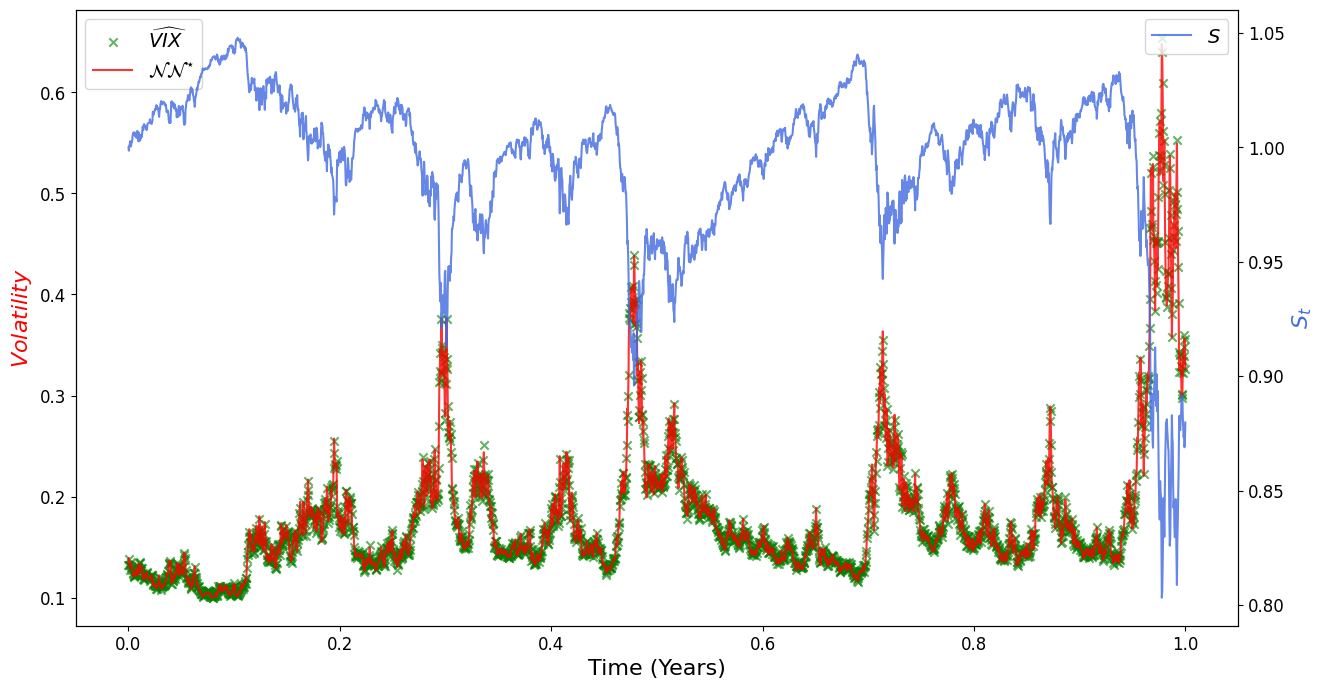

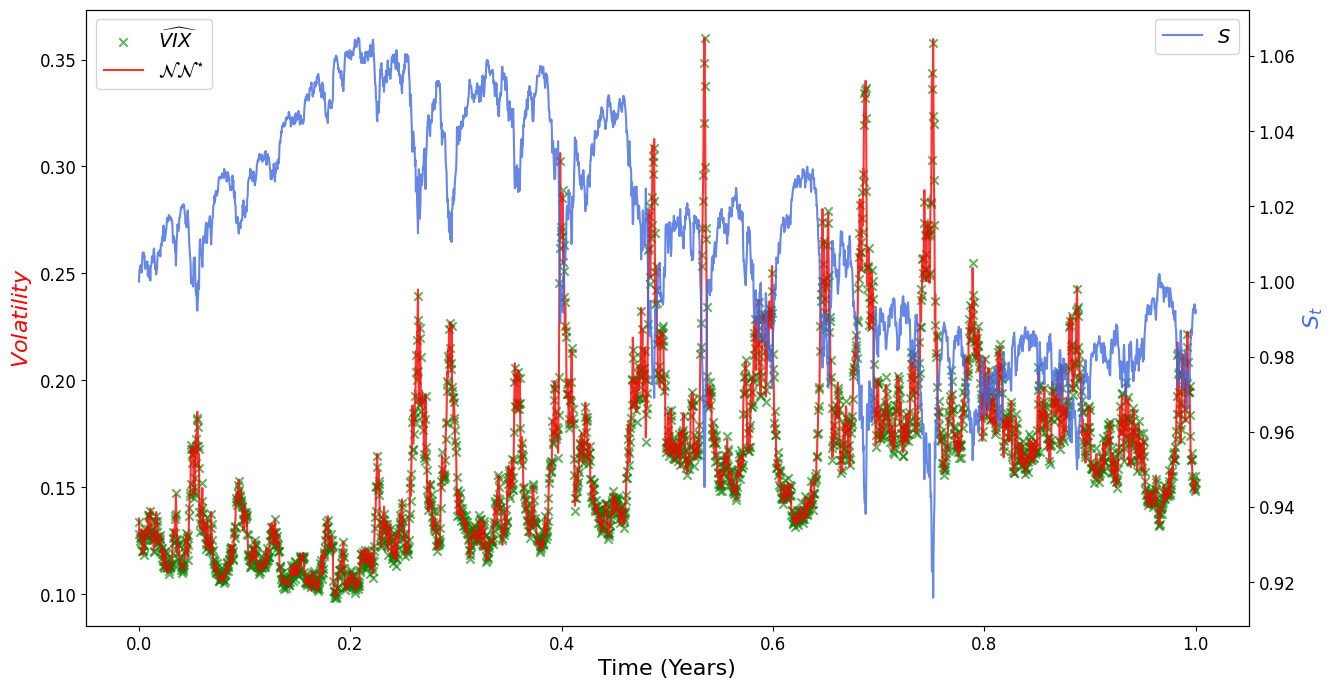

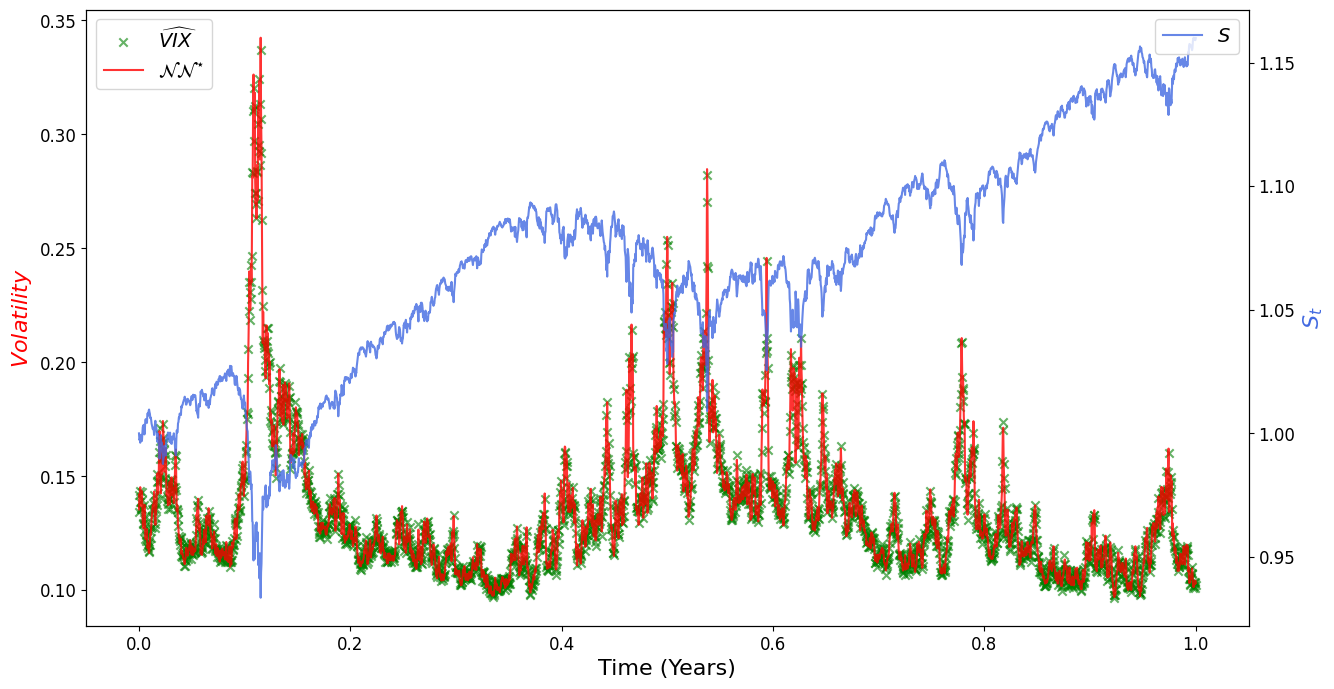

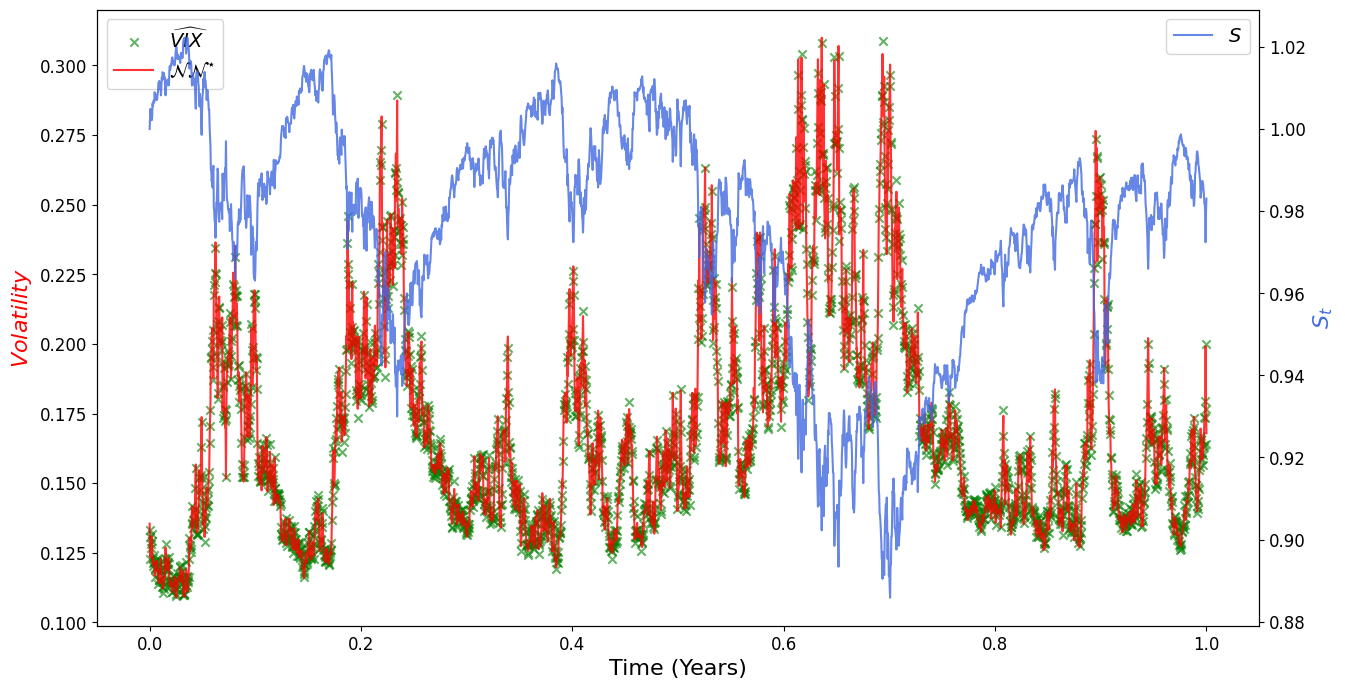

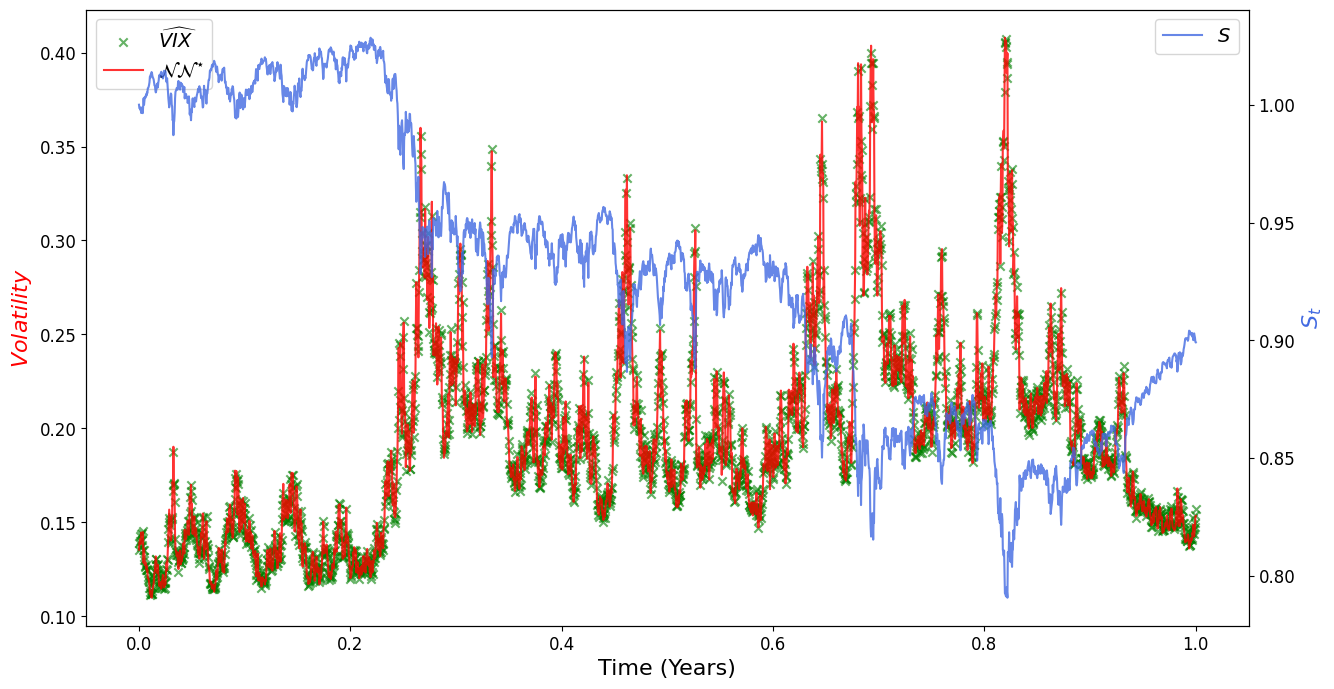

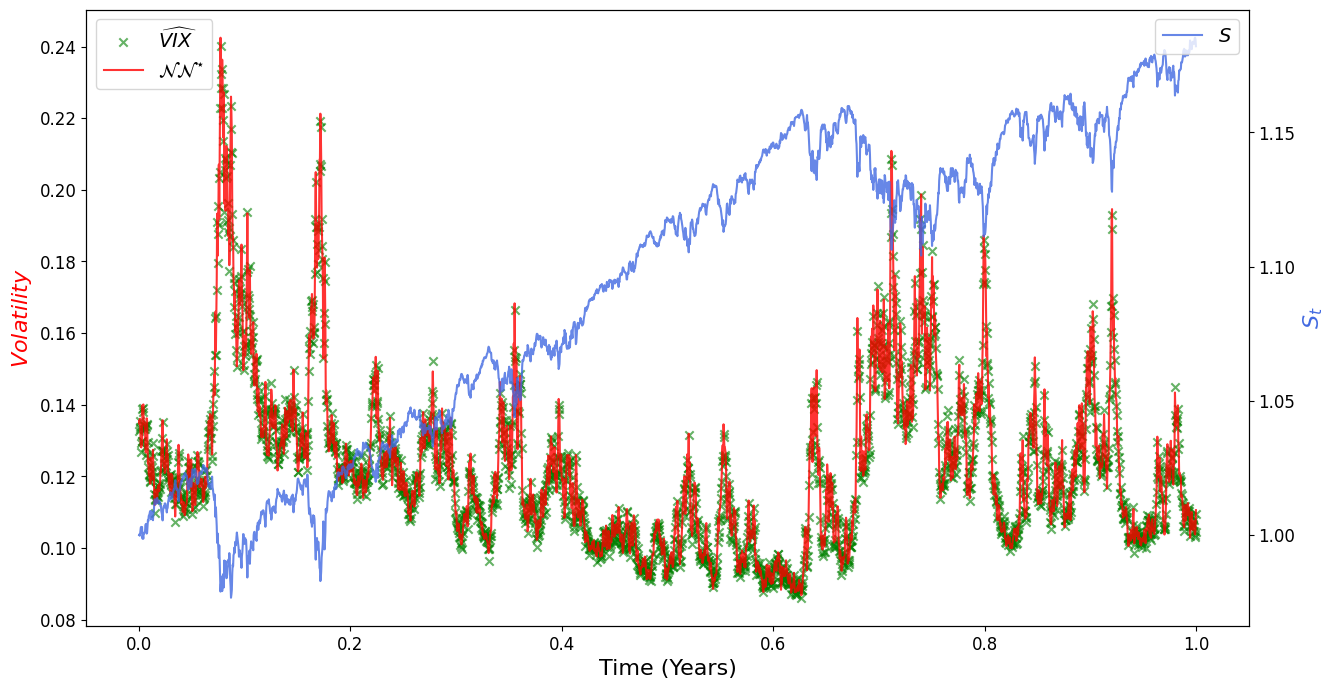

In [29]:
flag_save=True
flag_scatter=True

for j in range(N):
    fig, (ax1) = plt.subplots(1,1,figsize=(15,8))
    path_id =j 
    grid = np.linspace(0, maturity, maturity*252 * timestep_per_day)
    #grid_nested = np.linspace(0, maturity, maturity*252)

    ax2 = ax1.twinx()
    if flag_scatter:
        ax1.scatter(grid, vix_nested[path_id,:-1], color='green',marker='x',alpha=0.6, label=r'$\widehat{VIX}$')  # change color
    else:
        ax1.plot(grid, vix_nested[path_id,:-1], color='green', alpha=1.0, label=r'$\widehat{VIX}$')  # change color
    ax1.plot(grid, vixy[:, path_id, 0] / 100, color='red', alpha=0.8, label=r'$\mathcal{N}\mathcal{N}^{\star}$')
    ax2.plot(grid, torch_mc1.S_array[:-1, path_id], color='royalblue', alpha=0.8, label=r'$S$')

    # Adjust font size for labels
    ax1.set_ylabel(r'$Volatility$', color='red', fontsize=16)
    ax2.set_ylabel(r'$S_{t}$', color='royalblue', fontsize=16)
    ax1.set_xlabel('Time (Years)', fontsize=16)

    # Adjust font size for title
    #plt.title('Trajectories of ' + r'$\sigma$' + ' and ' + r'$S$' + ' and VIX for a 4-factor PDV model', fontsize=18)

    # Adjust font size for legends
    ax1.legend(loc='upper left', fontsize=14)
    ax2.legend(loc='upper right', fontsize=14)

    # Adjust tick label size
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)

    if flag_save:
        os.chdir(r'...\path_trajectories_vix_nested')
        if flag_scatter:
            fig.savefig('4FPDV_simulation_scatter_' + str(path_id) + '.png', format='png', dpi=300)
        else:
            fig.savefig('4FPDV_simulation_' + str(path_id) + '.png', format='png', dpi=300)
    #plt.grid()
    plt.show()
    
if flag_save:
    np.save('S.npy',torch_mc1.S_array.numpy())
    np.save('grid.npy',grid)
    np.save('vola.npy',torch_mc1.vol_array.numpy())
    np.save('vix_neural.npy',(vixy[:, :, 0]).numpy()/100)
    np.save('vix_nested.npy',vix_nested.numpy())

# <font color='royalblue'>Price light exotics</font>

\begin{align*}
    \text{Payoff 1}:\ \ (\text{VIX}_{T_1}-K)_+ {\bf 1}_{\{\inf_{t\in[0,T_1]} \frac{S_t}{S_0}\ge B\}}, \qquad
    \text{Payoff 2}: \ \ (K-\text{VIX}_{T_1})_+ {\bf 1}_{\{\sup_{t\in[0,T_1]} \frac{S_t}{S_0}\le B\}}
\end{align*}


In [7]:
# Jointly calibrated parameters as of 02/06/2021 (see Gazzani and Guyon ('24))

parameters=torch.tensor([44.42,33.19,4.311,3.254,0.0254,-0.1602,0.6922,0.1639,0.398,0.72]) 

lam10_k,lam11_k,beta1_k,beta12_k,theta1_k=parameters[0], parameters[1], parameters[5], parameters[7], parameters[8]
lam20_k,lam21_k=parameters[2], parameters[3]
beta0_k=parameters[4]
beta2_k=parameters[6]
theta2_k=parameters[-1]


R1_init_k,R2_init_k=torch.tensor([0.2689, 0.2375]),torch.tensor([0.0249,0.02491])

N=20000
timestep_per_day = 10 # number of timestep per business day
vix_N=10000
maturity=14/365+dt


torch_mc1 = TorchMonteCarloExponentialModel(lam1=torch.tensor([lam10_k,lam11_k]), lam2=torch.tensor([lam20_k,lam21_k]),
                                           betas=torch.tensor([beta0_k, beta1_k, beta2_k]), R_init1=R1_init_k,
                                           R_init2=R2_init_k,theta1=theta1_k, theta2=theta2_k, N=N, vix_N=vix_N,
                                           maturity=maturity, parabolic=beta12_k,
                                            parabolic_offset=torch.tensor(0),timestep_per_day=timestep_per_day,
                                            device=device) 

torch_mc1.simulate(save_R=True)

In [8]:
idx_mat=torch_mc1.index_of_timestamp(14/365)

In [49]:
tensor_vix_mat=torch.tensor([14/365])
list_of_mat_idxs_vix=torch.stack([torch_mc1.index_of_timestamp(tensor_vix_mat[j]) for j in range(len(tensor_vix_mat))]).to(device)

vixy=neural_vix(loaded_model,parameters,torch_mc1,mean_scaling_VIX,std_scaling_VIX,
                    mean_scaling_parameters,std_scaling_parameters,mean_scaling_Rs,
                    std_scaling_Rs,list_of_mat_idxs_vix,N,[0],device)

In [112]:
min_values, _ = torch.min(torch_mc1.S_array[:idx_mat], dim=0)

max_values, _ = torch.max(torch_mc1.S_array[:idx_mat], dim=0)

Observe that the following is just for illustrative purposes and clearly can just speeded up by 

Tensorization:
* Converted lists to PyTorch tensors for vectorized operations.
* Used broadcasting to avoid looping over elements.

Avoid Redundant Computations:
* Standard deviation (std) and means (mean) are calculated efficiently along the specified dimension.

In [115]:
list_B=[0.99,0.95,0.9,0.85,0.0]
list_K=[19,20,22.5,25,30,35,45]
Prices_payoff1=torch.zeros((len(list_B),len(list_K)))
Prices_payoff1_up=torch.zeros((len(list_B),len(list_K)))
Prices_payoff1_low=torch.zeros((len(list_B),len(list_K)))
for b,B in enumerate(list_B):
    indicator=min_values>=B
    for k,K in enumerate(list_K):
        payoff_values=torch.maximum(vixy.flatten()-K,torch.tensor(0))*indicator
        Prices_payoff1[b,k]=torch.mean(payoff_values)
        Prices_payoff1_up[b,k]=Prices_payoff1[b,k]+1.96*torch.std(payoff_values)/torch.sqrt(torch.tensor(N))
        Prices_payoff1_low[b,k]=Prices_payoff1[b,k]-1.96*torch.std(payoff_values)/torch.sqrt(torch.tensor(N))

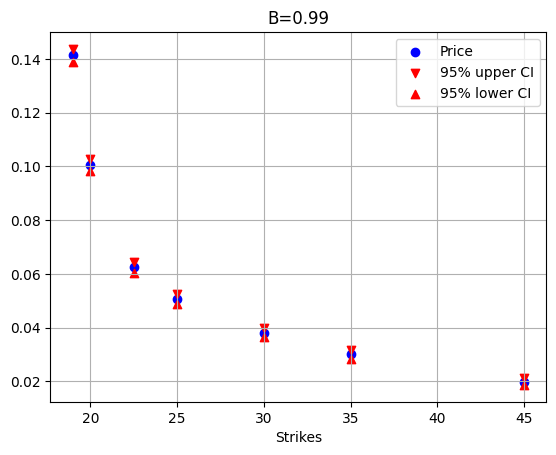

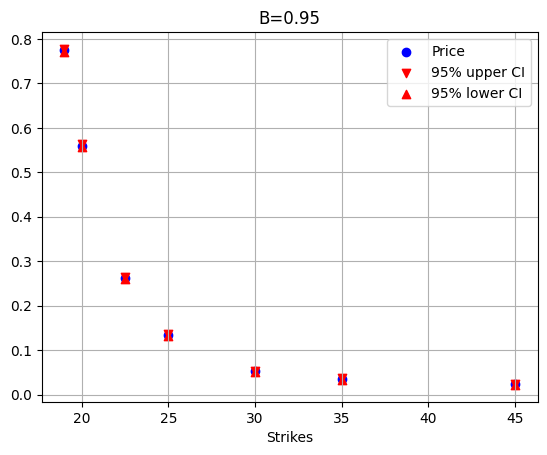

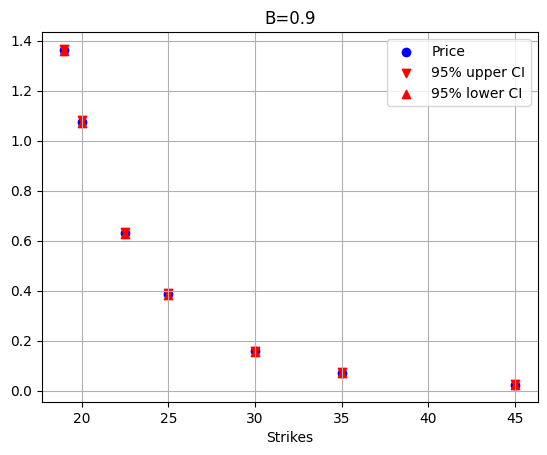

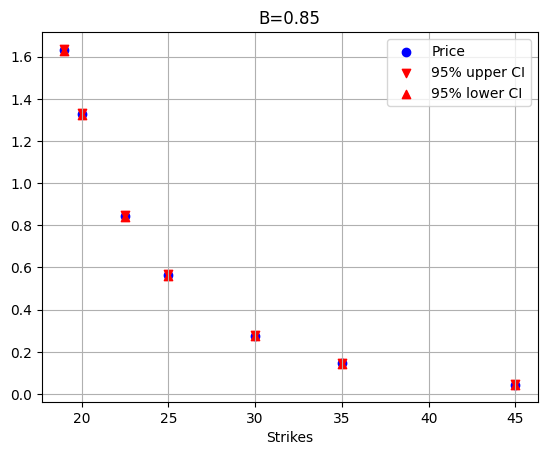

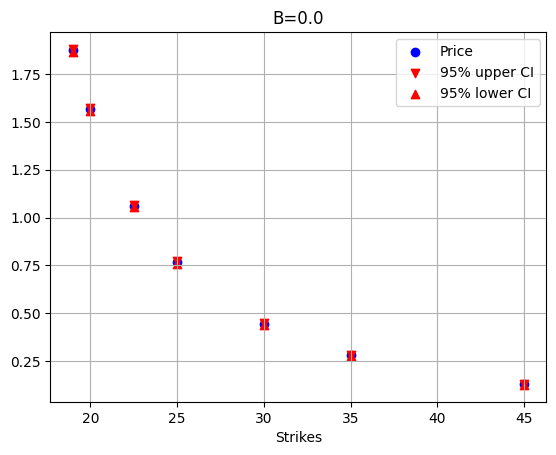

In [118]:
for b,B in enumerate(list_B):
    plt.figure()
    plt.scatter(list_K,Prices_payoff1[b,:],color='b',marker='o',label='Price')
    plt.scatter(list_K,Prices_payoff1_up[b,:],color='r',marker='v',label='95% upper CI')
    plt.scatter(list_K,Prices_payoff1_low[b,:],color='r',marker='^',label='95% lower CI')
    plt.title('B='+str(B))
    plt.xlabel('Strikes')
    plt.grid()
    plt.legend()
    plt.savefig('B='+str(B)+'.png',dpi=200)
    plt.show()

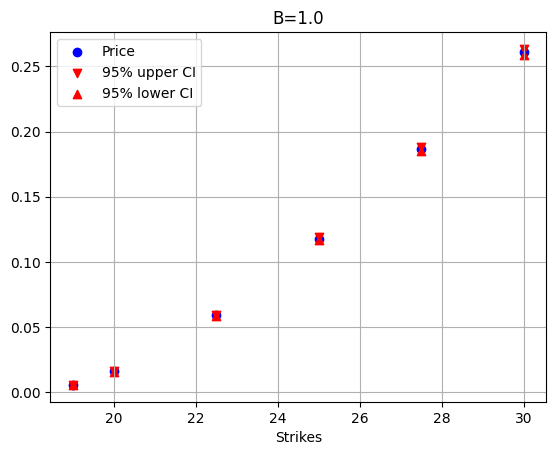

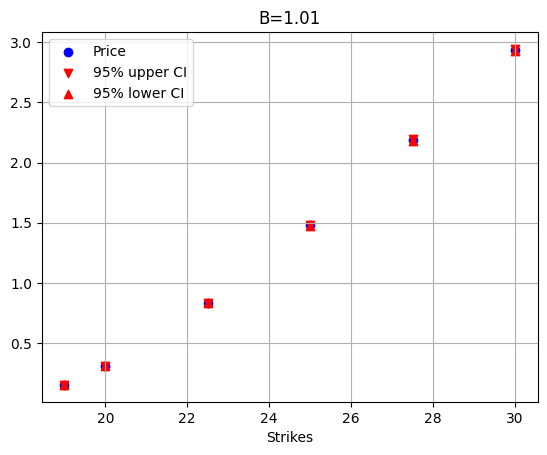

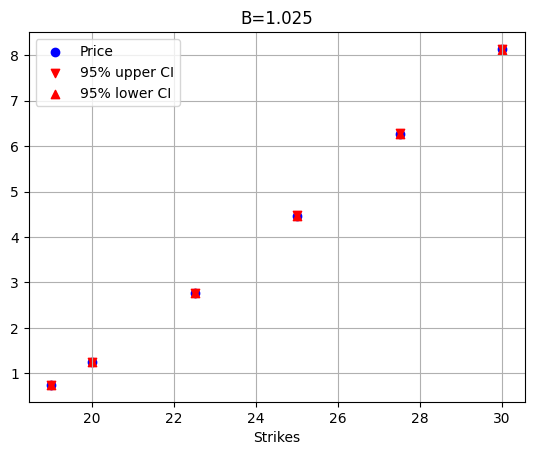

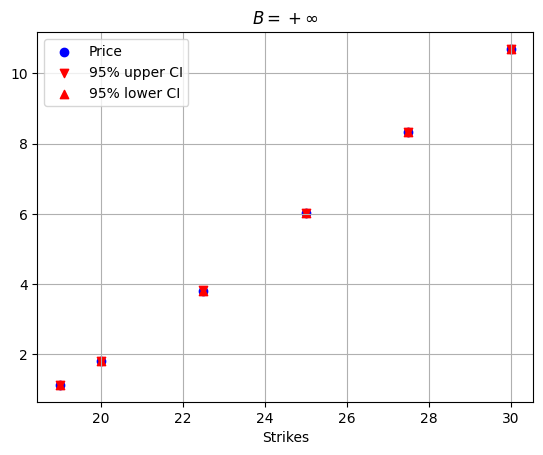

In [130]:
list_B_2=[1.0,1.01,1.025,10**4]
list_K_2=[17,18,20,22.5,25,27.5,30]
Prices_payoff2=torch.zeros((len(list_B_2),len(list_K_2)))
Prices_payoff2_up=torch.zeros((len(list_B_2),len(list_K_2)))
Prices_payoff2_low=torch.zeros((len(list_B_2),len(list_K_2)))
for b,B in enumerate(list_B_2):
    indicator=max_values<=B
    for k,K in enumerate(list_K_2):
        payoff_values=torch.maximum(K-vixy.flatten(),torch.tensor(0))*indicator
        Prices_payoff2[b,k]=torch.mean(payoff_values)
        Prices_payoff2_up[b,k]=Prices_payoff2[b,k]+1.96*torch.std(payoff_values)/torch.sqrt(torch.tensor(N))
        Prices_payoff2_low[b,k]=Prices_payoff2[b,k]-1.96*torch.std(payoff_values)/torch.sqrt(torch.tensor(N))
        
for b,B in enumerate(list_B_2):
    plt.figure()
    plt.scatter(list_K_2,Prices_payoff2[b,:],color='b',marker='o',label='Price')
    plt.scatter(list_K_2,Prices_payoff2_up[b,:],color='r',marker='v',label='95% upper CI')
    plt.scatter(list_K_2,Prices_payoff2_low[b,:],color='r',marker='^',label='95% lower CI')
    if B>1000:
        plt.title(r'$B=+\infty$')
    else:
        plt.title('B='+str(B))
    plt.xlabel('Strikes')
    plt.legend()
    plt.savefig('B='+str(B)+'.png',dpi=200)
    plt.grid()
    plt.show()